# Catmull-Rom Analysis
This Notebook contains all the analysis made directly on the Catmull-Rom CSV file.

## Libraries

In [1]:
library(plyr)

library(tidyverse)
library(DT) # dependency
library(ggthemes) # dependency

library(plotly)

Warning message:
"package 'plyr' was built under R version 3.3.3"Warning message:
"package 'tidyverse' was built under R version 3.3.3"Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Warning message:
"package 'ggplot2' was built under R version 3.3.3"Warning message:
"package 'tibble' was built under R version 3.3.3"Warning message:
"package 'tidyr' was built under R version 3.3.3"Warning message:
"package 'readr' was built under R version 3.3.3"Warning message:
"package 'purrr' was built under R version 3.3.3"Warning message:
"package 'dplyr' was built under R version 3.3.3"Conflicts with tidy packages ---------------------------------------------------
arrange():   dplyr, plyr
compact():   purrr, plyr
count():     dplyr, plyr
failwith():  dplyr, plyr
filter():    dplyr, stats
id():        dplyr, plyr
lag():       dplyr, stats
mutate():    dplyr, plyr
rename():    dplyr, plyr
summa

## Universal functions and variables

In [2]:
scenarios <- c("temperature", "rain", "sales", "gym_memberships", "wage", "facebook_friends")

readable_scenarios <- c("Temperature", "Rain", "Sales", "Gym members", "Salary", "FB Friends")

subconditions = c(1, 2, 3)

condition_names = c("Prior", "Posterior-Positive", "Posterior-Stable", "Posterior-Negative")

In [3]:
get_range <- function(condition){
    
    range_array <- switch(
            condition,
            temperature = c(-10, 40),
            sales = c(0, 5000),
            facebook_friends = c(0, 1000),
            rain = c(0, 100),
            gym_memberships = c(0, 50),
            wage = c(0, 50)
        )
    
    range_value <- range_array[2] - range_array[1]
    
    delta <- range_value / 10
    
    c(range_array[1] - delta, range_array[2] + delta)
}

In [4]:
to_pdf = TRUE

resolution = 30

## Preparing the data

In [5]:
data <- suppressWarnings(read_csv("data/catmull-rom-dataset.csv"))

data$noiseIndex <- data$noiseIndex+1

Parsed with column specification:
cols(
  .default = col_double(),
  userId = col_character(),
  age = col_character(),
  datetime = col_character(),
  gender = col_character(),
  datetime_1 = col_character(),
  stage = col_integer(),
  scenario = col_character(),
  subcondition = col_integer(),
  pageIndex = col_integer(),
  noiseIndex = col_integer(),
  day0 = col_character(),
  day1 = col_character(),
  day2 = col_character(),
  day3 = col_character(),
  day4 = col_character(),
  day5 = col_character(),
  day6 = col_character(),
  day7 = col_character(),
  day8 = col_character(),
  day9 = col_character()
  # ... with 69 more columns
)
See spec(...) for full column specifications.


### Suppress invalid participants
- `a021`: Response in Temperature (constant -10) indicates a non-interested participant.
- `a106`: Participant misunderstood the instructions and always added a point on the far right and far bottom.
- `a118`: Participant indicated that he had trouble with the interface.

In [6]:
participants <- data %>%
                select(userId, age, gender) %>%
                unique

data <- data %>%
            filter(#userId != 'a021',
                   userId != 'a106',
                   userId != 'a118')

Warning message:
"package 'bindrcpp' was built under R version 3.3.3"

# Tidy data (*tidyverse*)

In [7]:
# To tidy data
tidy_data <- data %>% 
    gather(day, value, starts_with("day"))

# Transform strings to numbers
tidy_data <- tidy_data %>%
    mutate(day = as.numeric(gsub("day", "", day)),
           value = as.numeric(value))

# Changes values to make them readable
# TODO: make this tidier:
tidy_data$subcondition_name <- mapvalues(tidy_data$subcondition,
                                  from = subconditions,
                                  to   = condition_names[2:4])

tidy_data$condition_name <- ifelse(tidy_data$stage==1,
                                   condition_names[1], 
                                   "")

tidy_data$condition_name <- ifelse(tidy_data$stage == 2, 
                                   tidy_data$subcondition_name, 
                                   tidy_data$condition_name)

Warning message in eval(substitute(expr), envir, enclos):
"NAs introduced by coercion"

# Participants

In [8]:
participants$age_number<- mapvalues(participants$age,
                              from = c('18-25',   '26-35',   '36-45',   '46-55',   '56-65',  '66+'),
                              to   = c((25-18)/2+18, (35-26)/2+26, (45-36)/2+36, (55-46)/2+46, (65-56)+56/2, 66))

participants$age_number <- as.numeric(participants$age_number)

### Age

In [9]:
participants %>%
    summarize(mean(age_number), sd(age_number)) %>%
    round(2)

mean(age_number),sd(age_number)
34.44,9.62


### Gender

In [10]:
participants %>%
    filter(gender == 'female') %>%
    nrow

[1] 55

### Total

In [11]:
participants %>%
    nrow

[1] 121

# Preparing the data for analysis

In [12]:
dat <- data.frame(
                    id        = tidy_data$userId,
                    day       = tidy_data$day, #x
                    value     = tidy_data$value, #y
                    condition = tidy_data$condition_name,
                    scenario  = tidy_data$scenario,
                    noise     = tidy_data$noiseIndex
                 )

# Change the readable names of the variables
dat$scenario <- mapvalues( dat$scenario, 
                           from = scenarios,
                           to = readable_scenarios)


# Order on the plot
dat$condition <- factor( dat$condition, 
                         levels = condition_names)

dat$scenario <- factor( dat$scenario, 
                        levels = readable_scenarios)

# Subset the analysis of data
dat <- subset(dat, day > 30 & day < 365*4-30)

# PLOTS

## Specific data for the plots

In [122]:
dplot <- subset(dat, day %in% seq(min(dat$day), max(dat$day), resolution))

### Mean plot

In [47]:
# Mean
trend <- dat %>%
    ddply(~scenario+condition+day, summarize, value=mean(value, trim=0.1))

trend$id <- "1"

p1 <- dplot %>%
        ggplot(aes(x=day, y=value, group=id)) + 
        geom_line(col="steelblue", alpha=0.2) +
        facet_grid(scenario~condition, scales="free_y") +
        theme_classic() + 
        xlab("Year") + 
        ylab("Values with mean") +
        geom_line(data=trend, aes(x=day, y=value), colour="black") +
        scale_x_continuous(breaks=c(0, 365, 365*2, 365*3), labels=c('Y1', 'Y2', 'Y3', 'Y4')) +
        geom_vline(data=filter(dplot, condition!="Prior"), aes(xintercept=365), colour="steelblue") +
        theme(  text = element_text(size=12, family="serif"),
                axis.line = element_line(colour="black", size=0.1),
                panel.spacing.x = unit(0.5, "lines"),
                panel.spacing.y = unit(0.8, "lines"),
                panel.background = element_blank(),
                panel.grid.major = element_blank(), 
                panel.grid.minor = element_blank(),
                panel.border = element_rect(colour="black", fill=NA, size=0.1))


#p1

svg("responses_with_mean.svg")
p1
dev.off()

png 
  2

### Variance

In [52]:
trend <- dat %>%
    ddply(~scenario+condition+day, summarize, value=var(value))

trend$id <- "1"

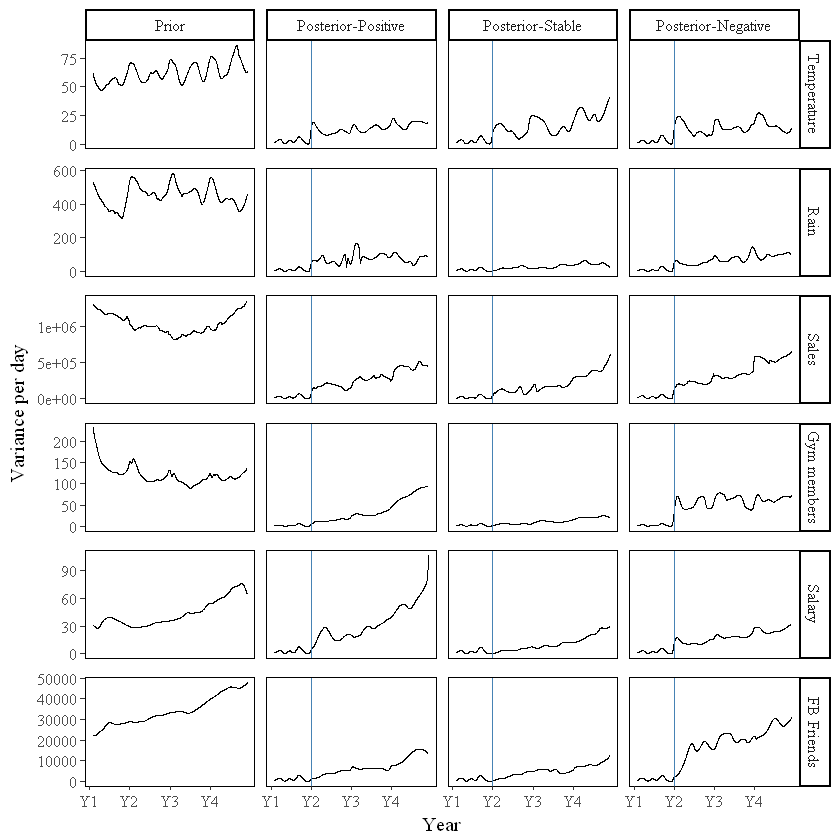

In [53]:
p2 <- dplot %>%
        ggplot(aes(x=day, y=value, group=id)) + 
        #geom_line(col="steelblue", alpha=0.2) +
        facet_grid(scenario~condition, scales="free_y") +
        theme_classic() + 
        xlab("Year") + 
        ylab("Variance per day") +
        geom_line(data=trend, aes(x=day, y=value), colour="black") +
        scale_x_continuous(breaks=c(0, 365, 365*2, 365*3), labels=c('Y1', 'Y2', 'Y3', 'Y4')) +
        geom_vline(data=filter(dplot, condition!="Prior"), aes(xintercept=365), colour="steelblue") +
        theme(  text = element_text(size=12, family="serif"),
                axis.line = element_line(colour="black", size=0.1),
                panel.spacing.x = unit(0.5, "lines"),
                panel.spacing.y = unit(0.8, "lines"),
                panel.background = element_blank(),
                panel.grid.major = element_blank(), 
                panel.grid.minor = element_blank(),
                panel.border = element_rect(colour="black", fill=NA, size=0.1))

p2

### Normalized variance

In [32]:
# Variance per scenario, condition, and day
variances <- dat %>%
                    group_by(scenario, condition, day) %>%
                    summarize(value_var = var(value))

In [34]:
norm_variances <- variances %>%
                        group_by(condition, day) %>%
                        mutate(scaled_value = scale(value_var))

In [36]:
norm_variances %>% head

scenario,condition,day,value_var,scaled_value
Temperature,Prior,31,60.40131,-0.4169304
Temperature,Prior,32,59.98923,-0.4169271
Temperature,Prior,33,59.57901,-0.4169243
Temperature,Prior,34,59.17427,-0.4169230
Temperature,Prior,35,58.77812,-0.4169224
Temperature,Prior,36,58.38566,-0.4169234


### Derivative (slope)

In [54]:
slope <- function( column ) {
    
    y1 = column$value[-1]
    
    y0 = column$value[-length(column$value)]
    
    return(y1-y0)
}

In [55]:
slopes <- ddply(dat, ~condition+scenario+id, slope)

slopes <- slopes %>% 
    gather(day, value, starts_with("V")) %>%
    mutate(day = as.numeric(gsub("V", "", day)))

# Order on the plot
slopes$condition <- factor( slopes$condition, 
                         levels = condition_names)

slopes$scenario <- factor( slopes$scenario, 
                        levels = readable_scenarios)

In [56]:
trend <- slopes %>%
    ddply(~scenario+condition+day, summarize, value=mean(value))

trend$id <- "1"

slopes_plot <- subset(slopes, day %in% seq(min(dat$day), max(dat$day), resolution))

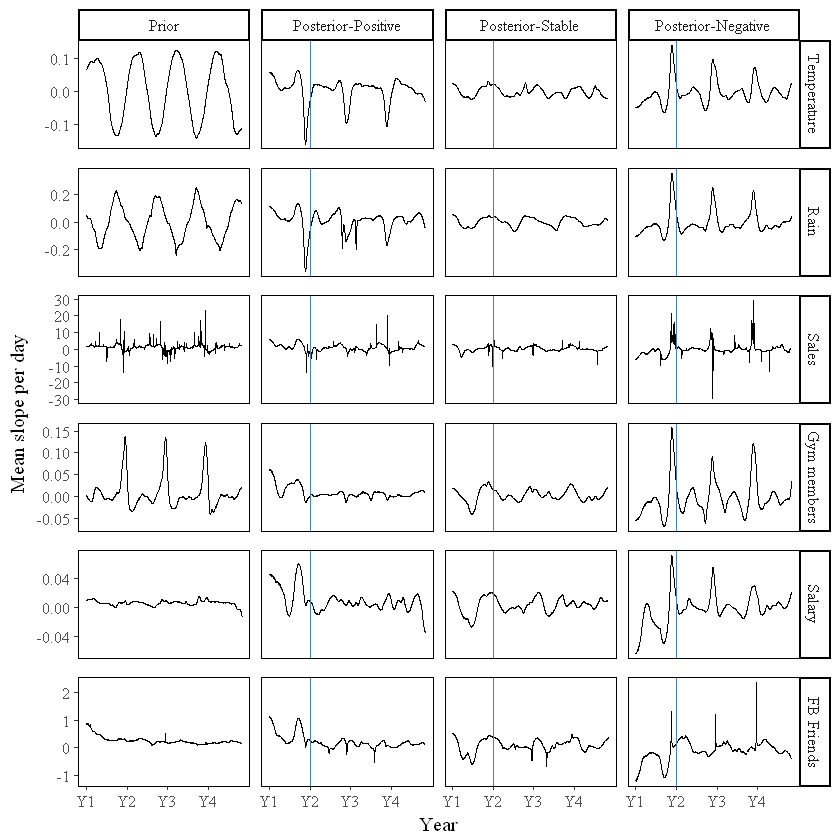

In [57]:
p3 <- slopes_plot %>%
        ggplot(aes(x=day, y=value, group=id)) + 
        #geom_line(col="steelblue", alpha=0.2) +
        facet_grid(scenario~condition, scales="free_y") +
        theme_classic() + 
        xlab("Year") + 
        ylab("Mean slope per day") +
        geom_line(data=trend, aes(x=day, y=value), colour="black") +
        scale_x_continuous(breaks=c(0, 365, 365*2, 365*3), labels=c('Y1', 'Y2', 'Y3', 'Y4')) +
        geom_vline(data=filter(dplot, condition!="Prior"), aes(xintercept=365), colour="steelblue") +
        theme(  text = element_text(size=12, family="serif"),
                axis.line = element_line(colour="black", size=0.1),
                panel.spacing.x = unit(0.5, "lines"),
                panel.spacing.y = unit(0.8, "lines"),
                panel.background = element_blank(),
                panel.grid.major = element_blank(), 
                panel.grid.minor = element_blank(),
                panel.border = element_rect(colour="black", fill=NA, size=0.1))

p3

In [32]:
pdf("compforecasts3.pdf")
p1
p2
p3
dev.off()

png 
  2

# One person's plot

In [104]:
dat <- data.frame(
                    id        = tidy_data$userId,
                    day       = tidy_data$day, #x
                    value     = tidy_data$value, #y
                    condition = tidy_data$condition_name,
                    scenario  = tidy_data$scenario
                 )

dat <- dat %>%
    filter(id == 'a106')

dat$condition <- factor( dat$condition, 
                         levels = c('Prior', 'Posterior-Positive', 'Posterior-Stable', 'Posterior-Negative', 'Posterior'))

# Change the readable names of the variables
dat$scenario <- mapvalues( dat$scenario, 
                           from = scenarios,
                           to = readable_scenarios)

dat[dat$condition != 'Prior', 'condition'] <- 'Posterior'

dat$condition <- factor( dat$condition, 
                         levels = c('Prior', 'Posterior'))

# Subset the data to be shown
dat <- subset(dat, day > 30 & day < 365*4-30)

dplot <- subset(dat, day %in% seq(min(dat$day), max(dat$day), resolution))

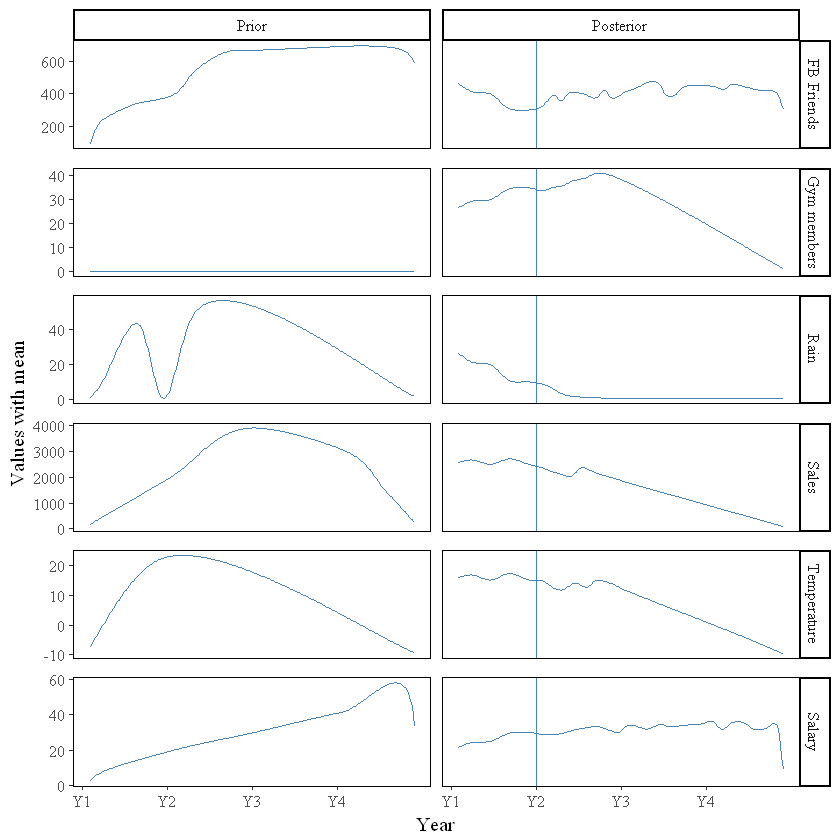

In [108]:
# Plot

pa <- dplot %>%
        filter(id == 'a106') %>%
        #filter(scenario == 'rain' || scenario == 'sales' || scenario == 'temperature' ) %>%
        ggplot(aes(x=day, y=value, group=id)) + 
        geom_line(col="steelblue", alpha=1.0) +
        facet_grid(scenario~condition, scales="free_y") +
        theme_classic() + 
        xlab("Year") + 
        ylab("Values") +
        scale_x_continuous(breaks=c(0, 365, 365*2, 365*3), labels=c('Y1', 'Y2', 'Y3', 'Y4')) +
        geom_vline(data=filter(dplot, condition!="Prior"), aes(xintercept=365), colour="steelblue") +
        theme(  text = element_text(size=12, family="serif"),
                axis.line = element_line(colour="black", size=0.1),
                panel.spacing.x = unit(0.5, "lines"),
                panel.spacing.y = unit(0.8, "lines"),
                panel.background = element_blank(),
                panel.grid.major = element_blank(), 
                panel.grid.minor = element_blank(),
                panel.border = element_rect(colour="black", fill=NA, size=0.1))


pa

# NORMALIZATION

Calculate the underlying trend

In [236]:
df <- dat %>%
        group_by(condition, scenario, day) %>%
        summarize(mean(value))

df$slope_scale <- mapvalues(df$condition,
                              from = c("Prior", "Posterior-Positive", "Posterior-Stable", "Posterior-Negative"),
                              to   = c(1, 1, 0, -1))

df$range <- mapvalues(df$scenario,
                              from = c("Temperature", "Rain", "Sales", "Gym members", "Salary", "FB Friends"),
                              to   = c( 40--10,        100-0,  5000-0,  50-0,          50-0,     1000-0))

df$y_intercept <- mapvalues(df$scenario,
                              from = c("Temperature", "Rain", "Sales", "Gym members", "Salary", "FB Friends"),
                              to   = c( 15,            30,     2500,    25,            20,       500))


# Transformations to numbers
df$slope_scale <- as.numeric(levels(df$slope_scale))[df$slope_scale]
df$range <- as.numeric(levels(df$range))[df$range]
df$y_intercept <- as.numeric(levels(df$y_intercept))[df$y_intercept]

# Calculations
df$last_point <- df$y_intercept + 0.05 * df$range * df$slope_scale * 4 

df$slope <- (df$last_point - df$y_intercept) / ((365-31)-1)

df$underlying_trend <- ((df$day-1) * df$slope + df$y_intercept)

scaling <- df %>%
                    group_by(condition, scenario) %>%
                    summarize(y_intercept = unique(y_intercept), last_point= unique(last_point), range = unique(range))


df <- df %>%
        select(condition, scenario, day, underlying_trend) %>%
        filter(condition!="Prior")

### Normalize data

In [168]:
norm_data <- dat %>%
                group_by(condition, scenario) %>%
                #group_by(scenario) %>%
                mutate(value_scaled = scale(value))

norm_data %>% head

id,day,value,condition,scenario,noise,value_scaled
a090,31,-2.368124,Prior,Temperature,1,-1.6432029
a090,31,49.745019,Prior,Rain,1,0.2676757
a090,31,554.935771,Prior,Sales,1,-1.8180913
a090,31,20.785377,Prior,Gym members,1,-0.5138010
a090,31,14.733540,Prior,Salary,1,-0.4183688
a090,31,583.408399,Prior,FB Friends,1,1.0239517


### Scale data (better than normalizing it)

In [203]:
scaling %>% head

condition,scenario,y_intercept,last_point,range
Prior,Temperature,15,25,50
Prior,Rain,30,50,100
Prior,Sales,2500,3500,5000
Prior,Gym members,25,35,50
Prior,Salary,20,30,50
Prior,FB Friends,500,700,1000


In [219]:
norm_data <- merge(x = dat, y = scaling, by = c("condition", "scenario"), all.x = TRUE)

norm_data <- norm_data %>%
                group_by() %>%
                mutate(value_scaled = (value - y_intercept)/(range))

In [220]:
norm_data <- norm_data %>%
                group_by() %>%
                #group_by(scenario) %>%
                mutate(value_norm = scale(value_scaled))

Trend

In [264]:
# Scale trend
trend <- merge(x = df, y = scaling, by = c("condition", "scenario"), all.x = TRUE)

trend <- trend %>%
            group_by() %>%
            mutate(underlying_trend_scaled = (underlying_trend - y_intercept)/(range))

In [267]:
# Normalize trend
means <- norm_data %>%
            group_by() %>%
            summarize(value_mean = mean(value_scaled),
                      value_sd = sd(value_scaled))

In [268]:
means

value_mean,value_sd
0.01455078,0.1929851


In [269]:
#trend <- merge(x = trend, y = means, by = c("condition", "scenario"), all.x = TRUE)

trend <- trend %>%
            mutate(underlying_trend_norm = ((underlying_trend_scaled - means$value_mean)/means$value_sd))

trend$id <- 1

trend %>%
        head

condition,scenario,day,underlying_trend,y_intercept,last_point,range,underlying_trend_scaled,value_mean,value_sd,underlying_trend_norm,id
Posterior-Negative,FB Friends,31,481.9820,500,300,1000,-0.01801802,-0.1689377,0.1277587,-0.1687633,1
Posterior-Negative,FB Friends,32,481.3814,500,300,1000,-0.01861862,-0.1689377,0.1277587,-0.1718755,1
Posterior-Negative,FB Friends,33,480.7808,500,300,1000,-0.01921922,-0.1689377,0.1277587,-0.1749876,1
Posterior-Negative,FB Friends,34,480.1802,500,300,1000,-0.01981982,-0.1689377,0.1277587,-0.1780998,1
Posterior-Negative,FB Friends,35,479.5796,500,300,1000,-0.02042042,-0.1689377,0.1277587,-0.1812120,1
Posterior-Negative,FB Friends,36,478.9790,500,300,1000,-0.02102102,-0.1689377,0.1277587,-0.1843241,1


### Plot: Trends

In [279]:
dplot <- subset(norm_data, day %in% seq(min(norm_data$day), max(norm_data$day), 5))

p <- dplot %>%
        ggplot(aes(x=day, y=value_norm, group=id)) + 
        geom_line(col="steelblue", alpha=0.2) +
        facet_grid(scenario~condition, scales="free_y") +
        theme_classic() + 
        xlab("Year") + 
        ylab("Scaled and normalized values") +
        geom_line(data=trend, aes(x=day, y=underlying_trend_norm), colour="black") +
        scale_x_continuous(breaks=c(0, 365, 365*2, 365*3), labels=c('Y1', 'Y2', 'Y3', 'Y4')) +
        scale_y_continuous(limits = c(-4, 4)) +
        geom_vline(data=filter(dplot, condition!="Prior"), aes(xintercept=365), colour="steelblue") +
        theme(  text = element_text(size=12, family="serif"),
                axis.line = element_line(colour="black", size=0.1),
                panel.spacing.x = unit(0.5, "lines"),
                panel.spacing.y = unit(0.8, "lines"),
                panel.background = element_blank(),
                panel.grid.major = element_blank(), 
                panel.grid.minor = element_blank(),
                panel.border = element_rect(colour="black", fill=NA, size=0.1))


svg("Images/responses_with_posterior_trends.svg")
p
dev.off()
#p

Warning message:
"Removed 167 rows containing missing values (geom_path)."

png 
  2

### Plot: trend damping
**`norm_data$value_norm`** and **`trend$underlying_trend_norm`** are the important datasets

In [324]:
# Filter out the prior condition and {temperature, rain} scenarios. Also filter out before year 1 and after year 4
filtered_norm_data <- norm_data %>%
        filter(condition != 'Prior', condition != 'Posterior-Stable', scenario != 'Temperature', scenario != 'Rain', day > 365-31, day <= 365*3 )

filtered_trend <- trend %>%
        filter(condition != 'Prior', condition != 'Posterior-Stable', scenario != 'Temperature', scenario != 'Rain', day > 365-31, day <= 365*3 )

In [382]:
dplot <- subset(filtered_norm_data, day %in% seq(min(norm_data$day), max(norm_data$day), 5))

p <- dplot %>%
        ggplot(aes(x=day, y=value_norm, group=id)) + 
        geom_line(col="steelblue", alpha=0.2) +
        facet_grid(scenario~condition, scales="free_y") +
        theme_classic() + 
        xlab("Year") + 
        ylab("Scaled and normalized values") +
        geom_line(data=filtered_trend, aes(x=day, y=underlying_trend_norm), colour="black") +
        scale_x_continuous(breaks=c(0, 365, 365*2, 365*3), labels=c('Y1', 'Y2', 'Y3', 'Y4')) +
        scale_y_continuous(limits = c(-4, 4)) +
        theme(  text = element_text(size=12, family="serif"),
                axis.line = element_line(colour="black", size=0.1),
                panel.spacing.x = unit(0.5, "lines"),
                panel.spacing.y = unit(0.8, "lines"),
                panel.background = element_blank(),
                panel.grid.major = element_blank(), 
                panel.grid.minor = element_blank(),
                panel.border = element_rect(colour="black", fill=NA, size=0.1))


svg("Images/trend_damping.svg", width=5, height=5)
p
dev.off()
#p

png 
  2

### Percentage of trend damping

In [461]:
# Selecting the relevant columns
aux <- filtered_trend %>% 
                    select(condition, scenario, day, underlying_trend_norm)

In [462]:
# Merging
trend_damping <- merge(x=filtered_norm_data, y=aux, by=c('condition', 'scenario', 'day'), all.x=TRUE)

# Above or below?
trend_damping$below <- trend_damping$value_norm < trend_damping$underlying_trend_norm

# Damped?
trend_damping$damped <- ifelse(trend_damping$condition == "Posterior-Positive", trend_damping$below, !trend_damping$below)

# Summarize overall scenarios
overall_damping <- trend_damping %>% 
                        group_by(condition, day) %>%
                        summarize(damped_proportion = sum(damped*1)/length(damped)) %>%
                        mutate(group = 1)

# Summarize per day
trend_damping_summary <- trend_damping %>% 
                            group_by(condition, scenario, day) %>%
                            summarize(damped_proportion = sum(damped*1)/length(damped))

Minimum and maximum

In [470]:
overall_damping %>%
    group_by(condition) %>%
    summarize(min.day = day[which.min(damped_proportion)], min.value = min(damped_proportion),
              max.day = day[which.max(damped_proportion)], max.value = max(damped_proportion)) 

condition,min.day,min.value,max.day,max.value
Posterior-Positive,338,0.7019868,714,1
Posterior-Negative,341,0.8711656,544,1


In [477]:
# T-test min
min1 <- trend_damping %>% 
            group_by(condition, day) %>%
            filter(condition=='Posterior-Positive', day == 338)

# T-test min 
min2 <- trend_damping %>% 
            group_by(condition, day) %>%
            filter(condition=='Posterior-Negative', day == 341)

t.test(min1$damped)
t.test(min2$damped)


	One Sample t-test

data:  min1$damped
t = 18.797, df = 150, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.6281959 0.7757776
sample estimates:
mean of x 
0.7019868 



	One Sample t-test

data:  min2$damped
t = 33.097, df = 162, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.8191884 0.9231429
sample estimates:
mean of x 
0.8711656 


#### Logarithmic model

In [546]:
# P-Positive
lm(damped_proportion ~ day*log(day), overall_damping %>% filter(condition=='Posterior-Positive')) %>% summary


Call:
lm(formula = damped_proportion ~ day * log(day), data = overall_damping %>% 
    filter(condition == "Posterior-Positive"))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.032563 -0.004295 -0.001129  0.003485  0.146967 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.216e+01  4.047e-01  -30.04   <2e-16 ***
day          -2.399e-02  1.205e-03  -19.91   <2e-16 ***
log(day)      2.690e+00  9.120e-02   29.50   <2e-16 ***
day:log(day)  2.688e-03  1.418e-04   18.95   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.01245 on 757 degrees of freedom
Multiple R-squared:  0.976,	Adjusted R-squared:  0.9759 
F-statistic: 1.028e+04 on 3 and 757 DF,  p-value: < 2.2e-16


In [544]:
# P-Negative
lm(damped_proportion ~ day*log(day), overall_damping %>% filter(condition=='Posterior-Negative')) %>% summary


Call:
lm(formula = damped_proportion ~ day * log(day), data = overall_damping %>% 
    filter(condition == "Posterior-Negative"))

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0195684 -0.0015893 -0.0000233  0.0012708  0.0184822 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -6.907e+00  1.377e-01  -50.16   <2e-16 ***
day          -1.794e-02  4.099e-04  -43.76   <2e-16 ***
log(day)      1.684e+00  3.103e-02   54.26   <2e-16 ***
day:log(day)  2.058e-03  4.825e-05   42.64   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.004237 on 757 degrees of freedom
Multiple R-squared:  0.9768,	Adjusted R-squared:  0.9767 
F-statistic: 1.064e+04 on 3 and 757 DF,  p-value: < 2.2e-16


#### Plot: trend damping summary

In [514]:
p <- trend_damping_summary %>%
        ggplot(aes(x=day, y=damped_proportion, group=scenario, color=scenario)) + 
        geom_line(size=1, alpha=0.7) +
        facet_grid(~condition, scales="free_y") +
        theme_classic() + 
        xlab("Year") + 
        ylab("Proportion of\ndamped predictions") +
        scale_x_continuous(breaks=c(0, 365, 365*2, 365*3), labels=c('Y1', 'Y2', 'Y3', 'Y4')) +
        scale_y_continuous(limits = c(0.6, 1)) +
        #geom_line(data=overall_damping, aes(x=day, y=damped_proportion, group=group), colour="black", size=1, alpha=0.5) +
        labs(colour = "Scenario") +
        theme(legend.position=c(0.88, 0.45)) +
        theme(  text = element_text(size=12, family="serif"),
                axis.line = element_line(colour="black", size=0.1),
                panel.spacing.x = unit(0.5, "lines"),
                panel.spacing.y = unit(0.8, "lines"),
                panel.background = element_blank(),
                panel.grid.major = element_blank(), 
                panel.grid.minor = element_blank(),
                panel.border = element_rect(colour="black", fill=NA, size=0.1))


svg("Images/trend_damping_proportion.svg", width=6, height=2.3)
#p
dev.off()
#p

png 
  2

In [504]:
Plotting overall trends

condition,day,damped_proportion,group
Posterior-Positive,335,0.8278146,1
Posterior-Positive,336,0.7682119,1
Posterior-Positive,337,0.7152318,1
Posterior-Positive,338,0.7019868,1
Posterior-Positive,339,0.7086093,1
Posterior-Positive,340,0.7152318,1


png 
  2

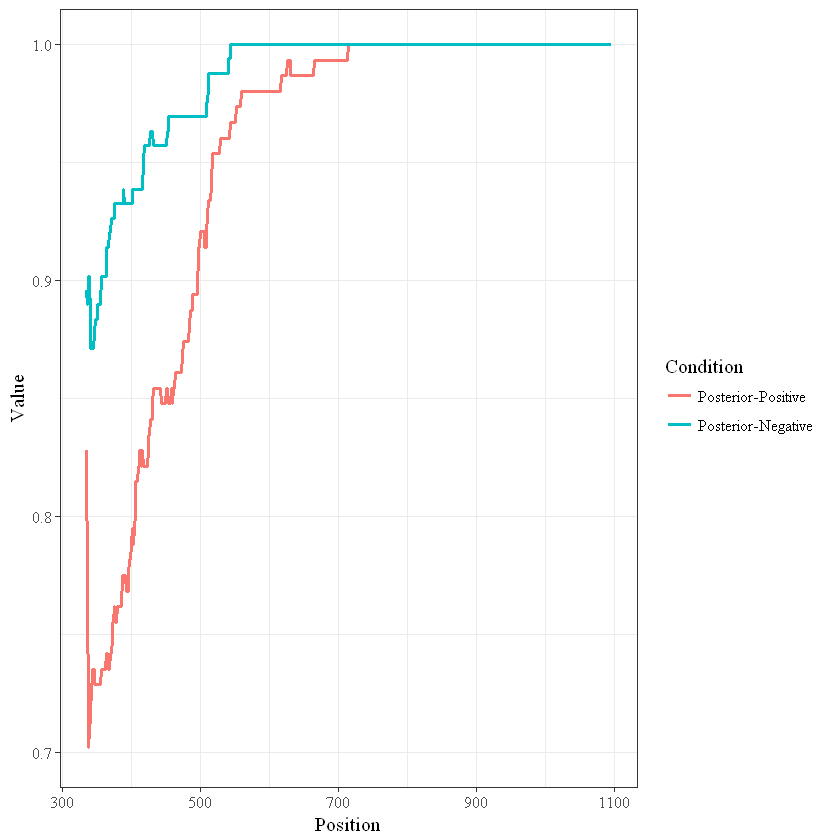

In [535]:
p <- ggplot(data=overall_damping, aes(x=day, y=damped_proportion, group=condition, colour=condition)) +
        geom_line(size=1) +
        expand_limits(y=0) +
        scale_y_continuous(limits = c(0.7, 1)) +
        labs(colour = "Condition") +
        xlab("Position") + ylab("Value") +
        theme_bw() +
        theme(text = element_text(size=12, family="serif"))

svg("Images/trend_damping_proportion.svg", width=6, height=2.3)
#p
dev.off()
p

# NOISE

In [235]:
g1 <- c( 0.7642726400978779,
         0.59420237112108,
         0.8045676111568967,
         0.3616072333221285,
         0.4333995695523616 )

g2 <- c( 0.44558333713334464,
         0.7720815219200008,
         0.091949620524298,
         0.3371284569763776,
         0.8147280055034919 )

g3 <- c( 0.6163862558959631,
         0.04367949448727826,
         0.057026095449790204,
         0.040766425126964156,
         0.17492704212711474 )


# Each group was substracted by its mean
g1 <- g1 - mean(g1)
g2 <- g2 - mean(g2)
g3 <- g3 - mean(g3)

# And then the last two were removed
n1 <- g1[1:3]
n2 <- g2[1:3]
n3 <- g3[1:3]

g1 <- c(0, n1, 0)
g2 <- c(0, n2, 0)
g3 <- c(0, n3, 0)

Calculting the noise profile of each group (as the mean of the absolute values)

In [262]:
# Noise profiles
np1 <- round(mean(abs(g1)),2)
np2 <- round(mean(abs(g2)),2)
np3 <- round(mean(abs(g3)),2)

c(np1, np2, np3)

[1] 0.08 0.15 0.14

### Plotting the noises

In [538]:
pdata <- rbind ( data.frame(value=g1, i=1:5, noise_group="1 (low)"),
                 data.frame(value=g2, i=1:5, noise_group="2 (highest)"),
                 data.frame(value=g3, i=1:5, noise_group="3 (high)"))

ERROR: Error in data.frame(value = g1, i = 1:5, noise_group = "1 (low)"): object 'g1' not found


In [537]:
p <- ggplot(data=pdata, aes(x=i, y=value, group=noise_group, colour=noise_group)) +
        geom_line(size=1) +
        geom_point(size=3, fill="white") +
        expand_limits(y=0) +  
        labs(colour = "Noise Group") +
        xlab("Position") + ylab("Value") +
        theme_bw()

        #theme(text = element_text(size=12, family="serif"))
        #theme(legend.position=c(.9, .7))

svg("Images/noise_groups.svg", width=8, height=3)
#p
dev.off()
p

ERROR: Error in ggplot(data = pdata, aes(x = i, y = value, group = noise_group, : object 'pdata' not found


### Influence per group noise

Calculate the mean value for each group of {condition, scenario, day, noise}

In [160]:
values_means <- norm_data %>%
                        group_by(condition, scenario, day, noise) %>%
                        summarize(value_mean = mean(value_scaled))

Merge the values_means into the normalized data

In [366]:
norm_data_2 <- merge(x = norm_data, y = values_means, by = c("day", "condition", "scenario", "noise"), all.x = TRUE)

Calculate the Mean Absolute error for each person, scenario, and noise group

In [400]:
MAEs_per_person <- norm_data_2 %>%
                    group_by(id, scenario, noise) %>%
                    summarize(MAE = sum(abs(value_mean - value_scaled)))

Calculate the mean of the mean absolute error

In [401]:
MAEs <- MAEs_per_person %>%
                    group_by(scenario, noise) %>%
                    summarize(mean_MAE = round(mean(MAE)), sd_MAE = round(sd(MAE)), count=length(MAE))

In [414]:
# Adding Std Error and Confidence Intervals
MAEs <- MAEs %>%
    mutate(    serror_MAE = round(sd_MAE / sqrt(count)),
               ci_95_bottom = round(mean_MAE - qt(0.05 / 2, count)*serror_MAE),
               ci_95_top = round(mean_MAE + qt(0.05 / 2, count)*serror_MAE))

In [415]:
MAEs %>%
    select(-sd_MAE, -count, -serror_MAE, -ci_95_bottom, -ci_95_top) %>%
    spread(noise, mean_MAE)

scenario,noise_profile,1,2,3
Temperature,0.08,1447,NA,NA
Temperature,0.14,NA,NA,1667
Temperature,0.15,NA,1859,NA
Rain,0.08,1429,NA,NA
Rain,0.14,NA,NA,1965
Rain,0.15,NA,2033,NA
Sales,0.08,1499,NA,NA
Sales,0.14,NA,NA,1983
Sales,0.15,NA,1997,NA
Gym members,0.08,1717,NA,NA


In [416]:
MAEs %>%
    select(-mean_MAE, -count, -sd_MAE, -ci_95_bottom, -ci_95_top) %>%
    spread(noise, serror_MAE)

scenario,noise_profile,1,2,3
Temperature,0.08,100,NA,NA
Temperature,0.14,NA,NA,103
Temperature,0.15,NA,146,NA
Rain,0.08,76,NA,NA
Rain,0.14,NA,NA,155
Rain,0.15,NA,146,NA
Sales,0.08,94,NA,NA
Sales,0.14,NA,NA,128
Sales,0.15,NA,121,NA
Gym members,0.08,97,NA,NA


### Regressions

In [417]:
# Adding the noise profiles
MAEs[MAEs$noise == 1, 'noise_profile'] <- np1
MAEs[MAEs$noise == 2, 'noise_profile'] <- np2
MAEs[MAEs$noise == 3, 'noise_profile'] <- np3

MAEs_per_person[MAEs_per_person$noise == 1, 'noise_profile'] <- np1
MAEs_per_person[MAEs_per_person$noise == 2, 'noise_profile'] <- np2
MAEs_per_person[MAEs_per_person$noise == 3, 'noise_profile'] <- np3

# Adding a cuadratic and cubic noise profile
MAEs_per_person$quadratic_np <- MAEs_per_person$noise_profile^2
MAEs_per_person$cubic_np <- MAEs_per_person$noise_profile^3

In [418]:
MAEs_per_person %>% head

id,scenario,noise,MAE,noise_profile,quadratic_np,cubic_np
a001,Temperature,3,1739.4741,0.14,0.0196,0.002744
a001,Rain,3,1240.7902,0.14,0.0196,0.002744
a001,Sales,3,1458.5372,0.14,0.0196,0.002744
a001,Gym members,3,2087.9279,0.14,0.0196,0.002744
a001,Salary,3,1616.0674,0.14,0.0196,0.002744
a001,FB Friends,3,883.5341,0.14,0.0196,0.002744


#### Linear regression

In [419]:
MAEs_scenario <- MAEs_per_person %>%
                    filter(scenario=='FB Friends')

fit <- lm(MAE ~ noise_profile, data=MAEs_scenario)
summary(fit)


Call:
lm(formula = MAE ~ noise_profile, data = MAEs_scenario)

Residuals:
    Min      1Q  Median      3Q     Max 
-1240.5  -631.5  -100.8   386.4  3574.9 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)     1222.4      306.7   3.986 0.000117 ***
noise_profile   3881.0     2435.9   1.593 0.113794    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 843.1 on 117 degrees of freedom
Multiple R-squared:  0.02124,	Adjusted R-squared:  0.01287 
F-statistic: 2.539 on 1 and 117 DF,  p-value: 0.1138


### Plots

In [420]:
MAEs %>% head

scenario,noise,mean_MAE,sd_MAE,count,serror_MAE,ci_95_bottom,ci_95_top,noise_profile
Temperature,1,1447,655,43,100,1649,1245,0.08
Temperature,2,1859,945,42,146,2154,1564,0.15
Temperature,3,1667,599,34,103,1876,1458,0.14
Rain,1,1429,501,43,76,1582,1276,0.08
Rain,2,2033,943,42,146,2328,1738,0.15
Rain,3,1965,901,34,155,2280,1650,0.14


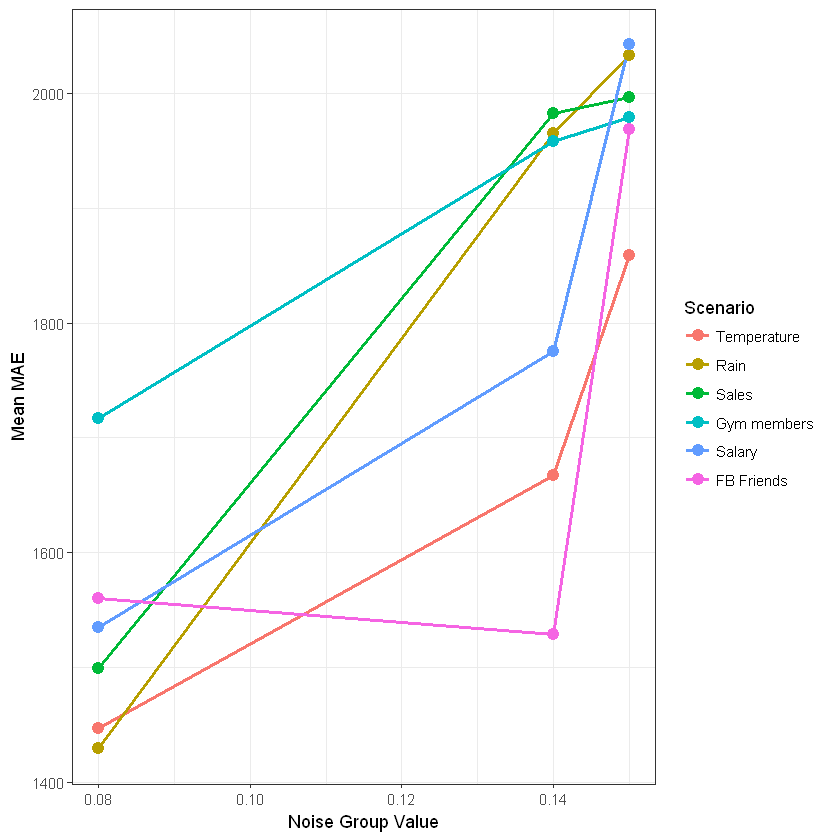

In [432]:
p <- ggplot(data=MAEs, aes(x=noise_profile, y=mean_MAE, group=scenario, colour=scenario)) +
        geom_line(size=1) +
        geom_point(size=3) +
        #expand_limits(y=1000) +  
        xlab("Noise Group Value") + ylab("Mean MAE") +
        theme_bw() +
        #geom_errorbar(aes(ymin=ci_95_bottom, ymax=ci_95_top), width=.005) +
        labs(colour = "Scenario")

svg("Images/MAEs_noise.svg", width=8, height=4)
#p
dev.off()
p